# 思想框架

1、数据预处理

2、特征选择-使用xgboost选择最重要的特征

3、数据不平衡处理-使用自步学习的方法处理fraud（0-1)分布不平衡造成的模型偏差

3、使用catboost进行分类预测

In [54]:
# 导入所需要的库
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import featuretools as ft

In [55]:
import xgboost
import lightgbm
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split,cross_validate,StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import roc_curve # 绘制ROC曲线
from sklearn.metrics import accuracy_score,roc_curve,roc_auc_score,f1_score,recall_score,precision_score
import matplotlib.pyplot as plt
import shap
import lime
# 利用shap方法解释
shap.initjs()
%matplotlib inline

# EDA

In [56]:
# 导入数据
train_data = pd.read_csv("./datasets/Vehicle Insurance Fraud Detection/carclaims.csv")
financial_data = train_data
financial_data.head(10).style.background_gradient(cmap='Dark2_r')# 查看缺失值

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,PolicyNumber,RepNumber,Deductible,DriverRating,Days-Policy-Accident,Days-Policy-Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,Year,BasePolicy,FraudFound
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,"more than 69,000",1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability,No
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,"more than 69,000",2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision,No
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,"more than 69,000",3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision,No
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,"20,000 to 29,000",4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability,No
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,"more than 69,000",5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision,No
5,Oct,4,Friday,Honda,Urban,Wednesday,Nov,1,Male,Single,20,Third Party,Sport - Collision,Sport,"more than 69,000",6,12,400,3,more than 30,more than 30,none,5 years,21 to 25,No,No,External,3 to 5,no change,1 vehicle,1994,Collision,No
6,Feb,1,Saturday,Honda,Urban,Monday,Feb,3,Male,Married,36,Third Party,Sport - Collision,Sport,"more than 69,000",7,14,400,1,more than 30,more than 30,1,7 years,36 to 40,No,No,External,1 to 2,no change,1 vehicle,1994,Collision,No
7,Nov,1,Friday,Honda,Urban,Tuesday,Mar,4,Male,Single,0,Policy Holder,Sport - Collision,Sport,"more than 69,000",8,1,400,4,more than 30,more than 30,1,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,Collision,No
8,Dec,4,Saturday,Honda,Urban,Wednesday,Dec,5,Male,Single,30,Policy Holder,Sport - Collision,Sport,"more than 69,000",9,7,400,4,more than 30,more than 30,none,6 years,31 to 35,No,Yes,External,3 to 5,no change,1 vehicle,1994,Collision,No
9,Apr,3,Tuesday,Ford,Urban,Wednesday,Apr,3,Male,Married,42,Policy Holder,Utility - All Perils,Utility,"more than 69,000",10,7,400,1,more than 30,more than 30,2 to 4,more than 7,36 to 40,No,No,External,3 to 5,no change,1 vehicle,1994,All Perils,No


# 数据结构探索

## 区分离散型变量和连续型变量

In [57]:
numercial_feature = list(financial_data.select_dtypes(exclude=['object']).columns) #数值型变量
object_feature = list(financial_data.select_dtypes(include=['object']).columns)
print('数值型变量：\n',numercial_feature,len(numercial_feature))
print('分类型变量：\n',object_feature,len(object_feature))

数值型变量：
 ['WeekOfMonth', 'WeekOfMonthClaimed', 'Age', 'PolicyNumber', 'RepNumber', 'Deductible', 'DriverRating', 'Year'] 8
分类型变量：
 ['Month', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed', 'MonthClaimed', 'Sex', 'MaritalStatus', 'Fault', 'PolicyType', 'VehicleCategory', 'VehiclePrice', 'Days-Policy-Accident', 'Days-Policy-Claim', 'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType', 'NumberOfSuppliments', 'AddressChange-Claim', 'NumberOfCars', 'BasePolicy', 'FraudFound'] 25


## 缺失值的处理

In [58]:
financial_data.isna().sum()

Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days-Policy-Accident    0
Days-Policy-Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange-Claim     0
NumberOfCars            0
Year                    0
BasePolicy              0
FraudFound              0
dtype: int64

In [59]:
financial_data.isnull().sum()

Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days-Policy-Accident    0
Days-Policy-Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange-Claim     0
NumberOfCars            0
Year                    0
BasePolicy              0
FraudFound              0
dtype: int64

In [60]:
# 连续型变量
serial_feature = []
# 离散型变量
discrete_feature = []
# 单值变量
unique_feature = []

for feature in numercial_feature:
    temp = financial_data[feature].nunique() #返回数据去重后的个数
    if temp == 1:
        unique_feature.append(feature)
    elif temp >1 and temp <= 10:
        discrete_feature.append(feature)
    else:
        serial_feature.append(feature)

## 连续型变量

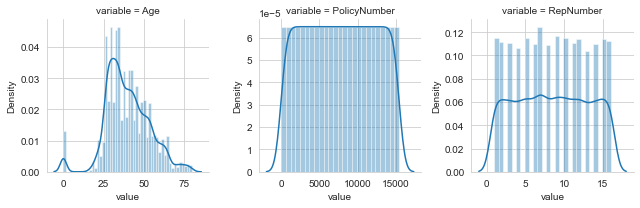

In [61]:
serial_df = pd.melt(financial_data,value_vars=serial_feature) #将连续型变量融合在一个dataframe中
f = sns.FacetGrid(serial_df,col='variable',col_wrap=3, sharex=False, sharey=False) # 生成画布，最多三列，不共享x、y轴
f.map(sns.distplot,"value")

## 离散型变量

In [62]:
for val in discrete_feature:
    temp = financial_data[val].nunique()
    print(val,'类型数',temp)

WeekOfMonth 类型数 5
WeekOfMonthClaimed 类型数 5
Deductible 类型数 4
DriverRating 类型数 4
Year 类型数 3


## 分类型变量

In [63]:
object_feature
financial_data[object_feature]

,Month,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,Sex,MaritalStatus,Fault,PolicyType,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,BasePolicy,FraudFound
0,Dec,Wednesday,Honda,Urban,Tuesday,Jan,Female,Single,Policy Holder,Sport - Liability,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,Liability,No
1,Jan,Wednesday,Honda,Urban,Monday,Jan,Male,Single,Policy Holder,Sport - Collision,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,Collision,No
2,Oct,Friday,Honda,Urban,Thursday,Nov,Male,Married,Policy Holder,Sport - Collision,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,Collision,No
3,Jun,Saturday,Toyota,Rural,Friday,Jul,Male,Married,Third Party,Sedan - Liability,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,Liability,No
4,Jan,Monday,Honda,Urban,Tuesday,Feb,Female,Single,Third Party,Sport - Collision,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,Collision,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,Nov,Friday,Toyota,Urban,Tuesday,Nov,Male,Married,Policy Holder,Sedan - Collision,...,6 years,31 to 35,No,No,External,none,no change,1 vehicle,Collision,Yes
15416,Nov,Thursday,Pontiac,Urban,Friday,Dec,Male,Married,Policy Holder,Sedan - Liability,...,6 years,31 to 35,No,No,External,more than 5,no change,3 to 4,Liability,No
15417,Nov,Thursday,Toyota,Rural,Friday,Dec,Male,Single,Policy Holder,Sedan - Collision,...,5 years,26 to 30,No,No,External,1 to 2,no change,1 vehicle,Collision,Yes
15418,Dec,Monday,Toyota,Urban,Thursday,Dec,Female,Married,Third Party,Sedan - All Perils,...,2 years,31 to 35,No,No,External,more than 5,no change,1 vehicle,All Perils,No


In [64]:
financial_data[object_feature].isna().any(axis=0)
# collision_type、property_damage、police_report_available有缺失值

Month                   False
DayOfWeek               False
Make                    False
AccidentArea            False
DayOfWeekClaimed        False
MonthClaimed            False
Sex                     False
MaritalStatus           False
Fault                   False
PolicyType              False
VehicleCategory         False
VehiclePrice            False
Days-Policy-Accident    False
Days-Policy-Claim       False
PastNumberOfClaims      False
AgeOfVehicle            False
AgeOfPolicyHolder       False
PoliceReportFiled       False
WitnessPresent          False
AgentType               False
NumberOfSuppliments     False
AddressChange-Claim     False
NumberOfCars            False
BasePolicy              False
FraudFound              False
dtype: bool

In [65]:
category_df = pd.concat([financial_data[object_feature],financial_data[discrete_feature[-1]]],axis=1)
n = len(object_feature) // 6
#fig,axes = plt.subplots(1,n,figsize=(20,5))
sns.set_style('whitegrid')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 [Text(0, 0, 'Month'),
  Text(1, 0, 'WeekOfMonth'),
  Text(2, 0, 'DayOfWeek'),
  Text(3, 0, 'Make'),
  Text(4, 0, 'AccidentArea'),
  Text(5, 0, 'DayOfWeekClaimed'),
  Text(6, 0, 'MonthClaimed'),
  Text(7, 0, 'WeekOfMonthClaimed'),
  Text(8, 0, 'Sex'),
  Text(9, 0, 'MaritalStatus'),
  Text(10, 0, 'Age'),
  Text(11, 0, 'Fault'),
  Text(12, 0, 'PolicyType'),
  Text(13, 0, 'VehicleCategory'),
  Text(14, 0, 'VehiclePrice'),
  Text(15, 0, 'PolicyNumber'),
  Text(16, 0, 'RepNumber'),
  Text(17, 0, 'Deductible'),
  Text(18, 0, 'DriverRating'),
  Text(19, 0, 'Days-Policy-Accident'),
  Text(20, 0, 'Days-Policy-Claim'),
  Text(21, 0, 'PastNumberOfClaims'),
  Text(22, 0, 'AgeOfVehicle'),
  Text(23, 0, 'AgeOfPolicyHolder'),
  Text(24, 0, 'PoliceReportFiled'),
  Text(25, 0, 'WitnessPresent'),
  Text(26, 0, 'AgentType'),
  Text(27, 0, 'NumberOfSuppliments')

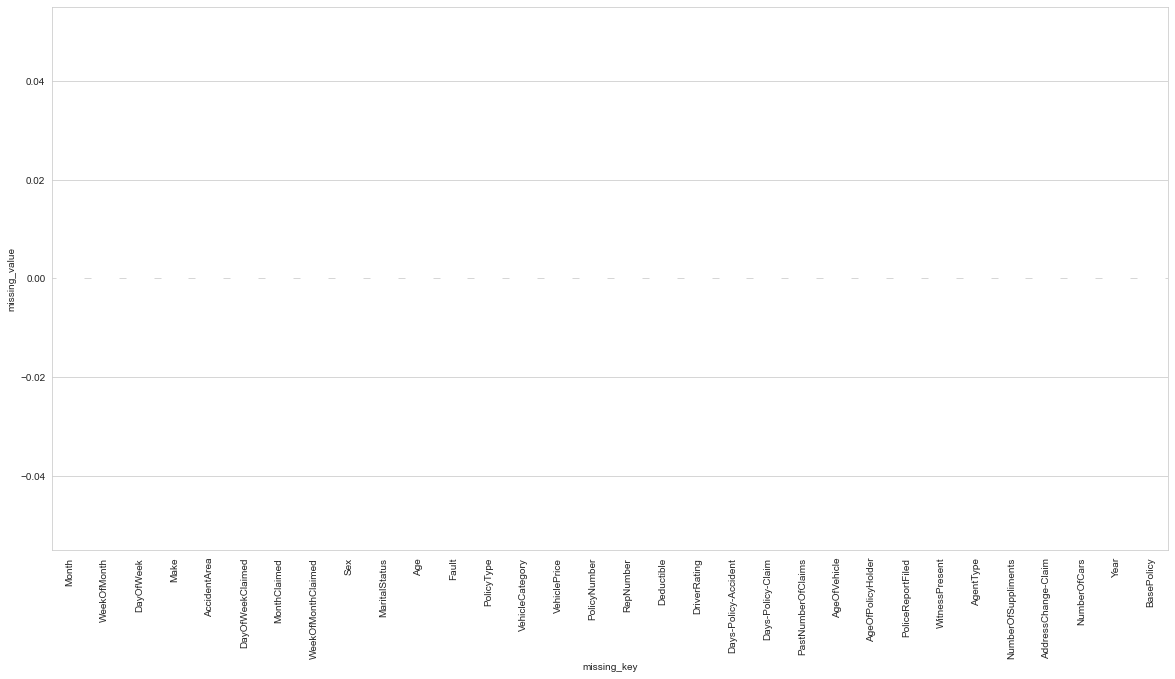

In [66]:
X_missing = financial_data.drop(columns='FraudFound')
missing = X_missing.isna().mean()
missing_df = pd.DataFrame({'missing_key':missing.keys(),'missing_value':np.round(missing.values,4)})
plt.figure(figsize=(20,10))
sns.barplot(data=missing_df,x='missing_key',y='missing_value')
plt.xticks(rotation=90)
# 缺失值都不超过50%，所以我们进行填充缺失值

## 变量相关性

<AxesSubplot: >

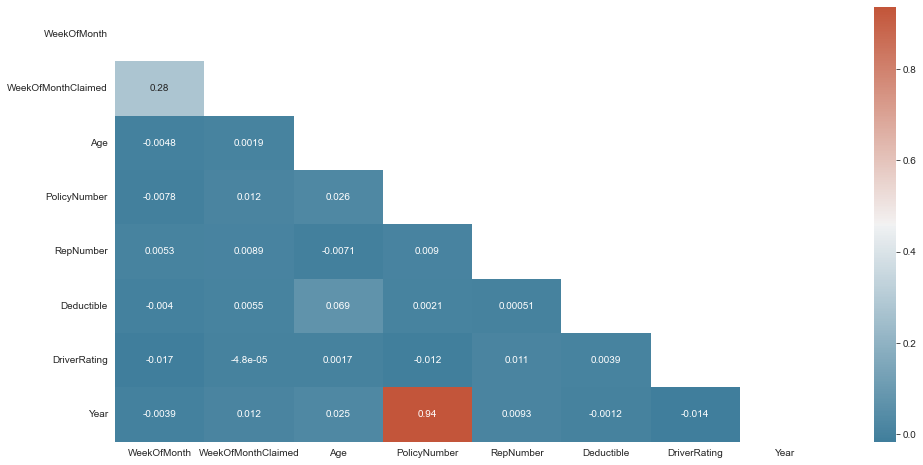

In [67]:
cor = financial_data[numercial_feature].corr()
# sns.set_theme(style="white")
plt.figure(figsize=(16,8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(cor, dtype=bool))
sns.heatmap(cor,mask=mask,cmap=cmap,annot = True)

# 特征工程--考虑使用自动特征工程工具featuretools构建新特征

## 缺失值的填充

In [68]:
missing_feature = list(missing_df[missing_df['missing_value'] != 0].missing_key) # 有缺失值的特征
financial_data[missing_feature] # 可以看出来都是分类型变量
for val in missing_feature:
    train_data[val] = train_data[val].fillna(train_data[val].mode()[0])
    test_data[val] = test_data[val].fillna(test_data[val].mode()[0])

## 异常值的处理

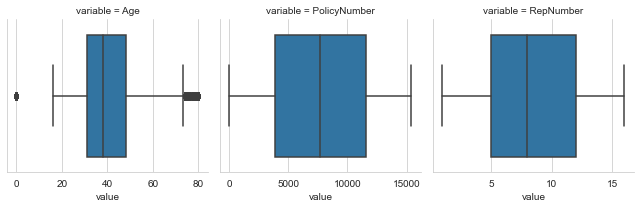

In [69]:
f_box = sns.FacetGrid(serial_df,col='variable',col_wrap=3, sharex=False, sharey=False) # 生成画布，最多三列，不共享x、y轴
f_box.map(sns.boxplot,"value") # 发现存在变量有异常 由于是特殊的风险预测，所以保留异常值

In [70]:
# data = train_data.drop(columns=['FraudFound'])
# lab = train_data['FraudFound']


# # 分离  数值变量与分类变量
# Nu_feature = list(data.select_dtypes(exclude=['object']).columns)  # 数值变量
# Ca_feature = list(data.select_dtypes(include=['object']).columns)  # 分类变量
# # print("新的数值变量为\n{}\n其数量为:{}".format(Nu_feature, len(Nu_feature)))
# # print("新的分类变量为\n{}\n其数量为:{}".format(Ca_feature, len(Ca_feature)))

# xgboost_clf = CatBoostClassifier(verbose=0) # xgboost模型

# xgboost_clf.fit(data,lab,cat_features=Ca_feature)

# explainer_shap = shap.KernelExplainer(xgboost_clf.predict_proba,data)

# # 解释第j条数据
# shap_values = explainer_shap.shap_values(data.iloc[10,:])
# shap.force_plot(explainer_shap.expected_value[0],shap_values[0],data.iloc[10,:])

## 标签编码

In [71]:
# 分离  数值变量与分类变量
Nu_feature = list(train_data.select_dtypes(exclude=['object']).columns)  # 数值变量
Ca_feature = list(train_data.select_dtypes(include=['object']).columns)  # 分类变量
print("新的数值变量为\n{}\n其数量为:{}".format(Nu_feature, len(Nu_feature)))
print("新的分类变量为\n{}\n其数量为:{}".format(Ca_feature, len(Ca_feature)))

新的数值变量为
['WeekOfMonth', 'WeekOfMonthClaimed', 'Age', 'PolicyNumber', 'RepNumber', 'Deductible', 'DriverRating', 'Year']
其数量为:8
新的分类变量为
['Month', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed', 'MonthClaimed', 'Sex', 'MaritalStatus', 'Fault', 'PolicyType', 'VehicleCategory', 'VehiclePrice', 'Days-Policy-Accident', 'Days-Policy-Claim', 'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType', 'NumberOfSuppliments', 'AddressChange-Claim', 'NumberOfCars', 'BasePolicy', 'FraudFound']
其数量为:25


In [72]:
# 对其余变量编码
from sklearn.preprocessing import LabelEncoder
Label = LabelEncoder()
for val in Ca_feature:
    Label.fit(train_data[val])
    train_data[val] = Label.transform(train_data[val])

## 特征选择
使用catboost的特征重要度对特征进行排序

In [73]:
train_data.corr()['FraudFound'].sort_values # 查看变量与fraud的相关系数
# 决定全部保留

<bound method Series.sort_values of Month                  -0.008670
WeekOfMonth            -0.011861
DayOfWeek              -0.017456
Make                   -0.019187
AccidentArea           -0.033499
DayOfWeekClaimed       -0.002065
MonthClaimed           -0.010247
WeekOfMonthClaimed     -0.005761
Sex                     0.029953
MaritalStatus           0.000568
Age                    -0.029741
Fault                  -0.131389
PolicyType             -0.057057
VehicleCategory        -0.099198
VehiclePrice            0.061541
PolicyNumber           -0.020345
RepNumber              -0.007551
Deductible              0.017348
DriverRating            0.007266
Days-Policy-Accident    0.005529
Days-Policy-Claim      -0.015400
PastNumberOfClaims      0.023363
AgeOfVehicle           -0.022236
AgeOfPolicyHolder      -0.031966
PoliceReportFiled      -0.016007
WitnessPresent         -0.008057
AgentType              -0.022978
NumberOfSuppliments     0.013264
AddressChange-Claim    -0.037640
NumberO

In [74]:
# 显示相关性高于0.6的变量
def getHighRelatedFeatureDf(corr_matrix, corr_threshold):
    highRelatedFeatureDf = pd.DataFrame(corr_matrix[corr_matrix > corr_threshold].stack().reset_index())
    highRelatedFeatureDf.rename({'level_0':'feature1','level_1':'feature2',0:'corr'},axis=1,inplace=True) # 更改列名
    highRelatedFeatureDf = highRelatedFeatureDf[highRelatedFeatureDf.feature1 != highRelatedFeatureDf.feature2] # 去除自己和自己
    highRelatedFeatureDf['feature_pair_key'] = highRelatedFeatureDf.loc[:,['feature1', 'feature2']].apply(lambda r:'#'.join(np.sort(r.values)), axis=1)
    # 将feature1和feature2名称连接在一起去重
    highRelatedFeatureDf.drop_duplicates(subset=['feature_pair_key'],inplace=True)
    highRelatedFeatureDf.drop(columns='feature_pair_key',inplace=True)
    return highRelatedFeatureDf

In [75]:
getHighRelatedFeatureDf(train_data.corr(),0.3)
# age_of_driver和annual_income有明显相关性，暂时都不删除
# 删除injury_claim

,feature1,feature2,corr
1,Month,MonthClaimed,0.724350
13,Age,AgeOfVehicle,0.417000
14,Age,AgeOfPolicyHolder,0.971634
17,PolicyType,VehicleCategory,0.862276
18,PolicyType,BasePolicy,0.510542
21,VehicleCategory,BasePolicy,0.631512
24,PolicyNumber,Year,0.936513
29,Days-Policy-Accident,Days-Policy-Claim,0.387361
35,AgeOfVehicle,AgeOfPolicyHolder,0.405090


In [76]:
y = train_data['FraudFound']
x = train_data.drop(columns=['FraudFound'])
x

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,Year,BasePolicy
0,2,5,6,6,1,6,5,1,0,2,...,1,3,0,0,0,3,0,2,1994,2
1,4,3,6,6,1,2,5,4,1,2,...,4,4,1,0,0,3,3,0,1994,1
2,10,5,0,6,1,5,10,2,1,1,...,5,6,0,0,0,3,3,0,1994,1
3,6,2,2,17,0,1,6,1,1,1,...,6,7,1,0,0,2,3,0,1994,2
4,4,5,1,6,1,6,4,2,0,2,...,3,4,0,0,0,3,3,0,1994,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,9,4,0,17,1,6,10,5,1,1,...,4,4,0,0,0,3,3,0,1996,1
15416,9,5,4,13,1,1,3,1,1,1,...,4,4,0,0,0,2,3,2,1996,2
15417,9,5,4,17,0,1,3,1,1,2,...,3,3,0,0,0,0,3,0,1996,1
15418,2,1,1,17,1,5,3,2,0,1,...,0,4,0,0,0,2,3,0,1996,0


In [77]:
X=np.asarray(x)
y=np.asarray(y)
X


array([[   2,    5,    6, ...,    2, 1994,    2],
       [   4,    3,    6, ...,    0, 1994,    1],
       [  10,    5,    0, ...,    0, 1994,    1],
       ...,
       [   9,    5,    4, ...,    0, 1996,    1],
       [   2,    1,    1, ...,    0, 1996,    0],
       [   2,    2,    6, ...,    0, 1996,    1]], dtype=int64)

In [78]:
y

array([0, 0, 0, ..., 1, 0, 1])

In [79]:
# 划分数据集为测试集和训练集
# X=np.asarray(x)
# y=np.asarray(y)
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7)
#simple_X_train,simple_X_test,simple_y_train,simple_y_test = train_test_split(simple_X,simple_y,train_size=0.7)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

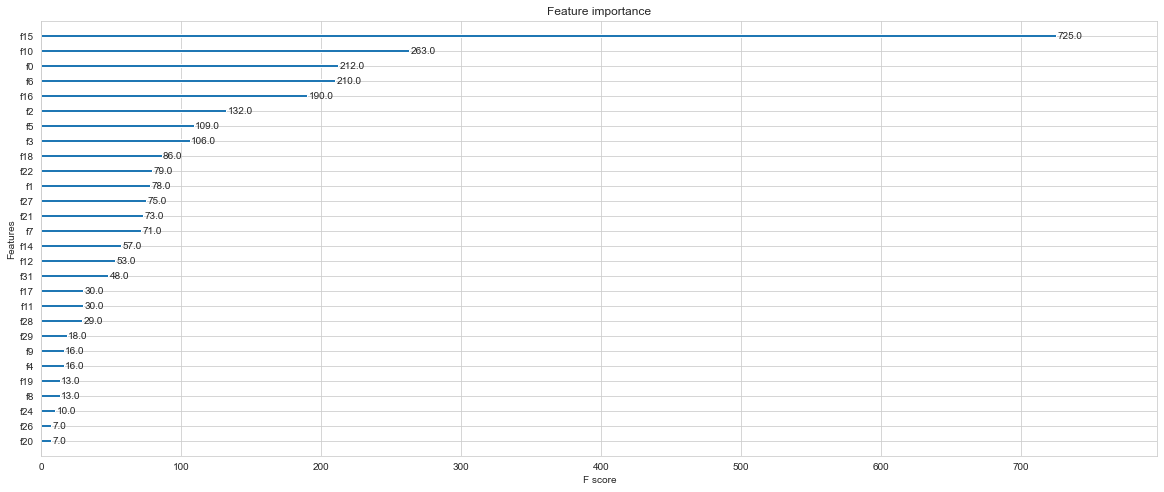

In [80]:
# 特征重要性排序
from xgboost import plot_importance
xgboost_clf = xgboost.XGBClassifier() # xgboost模型
xgboost_clf.fit(X_train,y_train)
fig,ax = plt.subplots(figsize=(20,8))
plot_importance(xgboost_clf,ax=ax)

In [81]:
cat_pred = xgboost_clf.predict(X_test)
cat_proba = xgboost_clf.predict_proba(X_test)[:,1]
print('acc of test:',accuracy_score(y_test,cat_pred))
print('auc of test:',roc_auc_score(y_test,cat_proba))

acc of test: 0.9444444444444444
auc of test: 0.9498033163882835


# 构建模型

## 根据参数构建模型

In [82]:
# Catboost模型
Catboost_params = {'loss_function': 'CrossEntropy',  # LoglossObjective() # 损失函数，取值RMSE, Logloss, MAE, CrossEntropy,
                  # Quantile, LogLinQuantile, Multiclass, MultiClassOneVsAll, MAPE, Poisson。默认Logloss。
                    'learning_rate': 0.01,
                   'max_depth': 6, 
                   'l2_leaf_reg': 9, 
                   'bootstrap_type': 'Bernoulli',
                  'od_type': 'Iter', 
                   'od_wait': 50, 
                   'random_seed': 11, 
                   'allow_writing_files': False,
                  'eval_metric': 'AUC',
                  'verbose':0}

catboost_clf1 = CatBoostClassifier(**Catboost_params)# Catboost模型
catboost_clf2 = CatBoostClassifier(verbose=0)# Catboost模型

# lightgbm模型
lightgbm_params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc',
            'min_child_samples': 22,
            'min_child_weight': 0.001,
            'n_estimators': 30,
            'num_leaves': 15,
            'max_depth': 6,
            'force_row_wise':True,
            'learning_rate': 0.1,
            'verbose':0}
lightgbm_clf1 = lightgbm.LGBMClassifier(**lightgbm_params) # 决策树模型
lightgbm_clf2 = lightgbm.LGBMClassifier(force_row_wise=True,verbose=0) # 决策树模型

# xgboost
xgboost_param = {
    'learning_rate':0.01,
    'colsample_bytree': 0.6,
    'gamma': 0.2,
    'max_depth': 7,
    'min_child_weight': 0.01,
    'subsample': 0.7}
xgboost_clf1 = xgboost.XGBClassifier(**xgboost_param) # xgboost模型
xgboost_clf2 = xgboost.XGBClassifier() # xgboost模型

# 集合算法树模型
GBDT_param = {
    'loss':'exponential',
    'learning_rate':0.1,
    'n_estimators':300,
    'max_depth':5,
    'min_samples_split':10,
    'subsample':0.7,
    'verbose':0
}
GBDT_clf1 = GradientBoostingClassifier(**GBDT_param)# GBDT模型
GBDT_clf2 = GradientBoostingClassifier(verbose=0)# GBDT模型


In [83]:
import warnings
warnings.filterwarnings('ignore')

# 暂时不需要训练
lightgbm_clf1.fit(X_train,y_train) 

stacking_pred = lightgbm_clf1.predict(X_test)
stacking_proba = lightgbm_clf1.predict_proba(X_test)[:,1]
print("lightGBM")
print('acc of test:',accuracy_score(y_test,stacking_pred))
print('auc of test:',roc_auc_score(y_test,stacking_proba))


xgboost_clf1.fit(X_train,y_train)


stacking_pred = xgboost_clf1.predict(X_test)
stacking_proba = xgboost_clf1.predict_proba(X_test)[:,1]
print("XGBoost")
print('acc of test:',accuracy_score(y_test,stacking_pred))
print('auc of test:',roc_auc_score(y_test,stacking_proba))


GBDT_clf1.fit(X_train,y_train)

stacking_pred = GBDT_clf1.predict(X_test)
stacking_proba = GBDT_clf1.predict_proba(X_test)[:,1]
print("GBDT")
print('acc of test:',accuracy_score(y_test,stacking_pred))
print('auc of test:',roc_auc_score(y_test,stacking_proba))

catboost_clf1.fit(X_train,y_train)

stacking_pred = catboost_clf1.predict(X_test)
stacking_proba = catboost_clf1.predict_proba(X_test)[:,1]
print("Catboost")
print('acc of test:',accuracy_score(y_test,stacking_pred))
print('auc of test:',roc_auc_score(y_test,stacking_proba))

lightGBM
acc of test: 0.9349329874621704
auc of test: 0.8544098735173082
XGBoost
acc of test: 0.9349329874621704
auc of test: 0.8263737593802953
GBDT
acc of test: 0.9427150886294855
auc of test: 0.9428097010409102
Catboost
acc of test: 0.9347168179853005
auc of test: 0.892485929557008


## 构建集成模型

In [84]:
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingCVClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

sclf = StackingCVClassifier(classifiers=[GBDT_clf1,GBDT_clf2,lightgbm_clf1,lightgbm_clf2,xgboost_clf1,xgboost_clf2,catboost_clf1,catboost_clf2],
                            use_probas=True,  
                            meta_classifier=LogisticRegression(verbose=0),
                            random_state=42, cv=5,verbose=0,n_jobs=8)
# scores = cross_val_score(sclf, mean_X_train,y_label,cv=5, scoring='roc_auc')
# print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label)) 


# acc = accuracy_score(valid_y, stacking_pred)# 计算准确度
# auc = roc_auc_score(valid_y, cat_pred)# 计算ROC, AUC


# print('验证集acc:\t{}'.format(acc))
# print('验证集auc:\t{}'.format(auc))

# for clf, label in zip([lightgbm_clf,xgboost_clf,Catboost_clf, sclf], 
#                       ['lightgbm', 
#                        'xgboost', 
#                        'Catboost',
#                        'StackingClassifier']):
 
#     scores = cross_val_score(clf, mean_X_train,y_label,cv=5, scoring='roc_auc')
#     print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
#           % (scores.mean(), scores.std(), label)) 


# clf.predict(mean_X_train,y_label)

# 模型预测与融合

直接进行模型融合

In [31]:
sclf.fit(x,y)

stacking_pred = sclf.predict(X_test)
stacking_proba = sclf.predict_proba(X_test)[:,1]
print('acc of test:',accuracy_score(y_test,stacking_pred))
print('auc of test:',roc_auc_score(y_test,stacking_proba))

# acc of test: 0.9915693904020753
# auc of test: 0.9988817617684546

acc of test: 0.9937310851707739
auc of test: 0.9993050723529313


# 自步学习的思想处理不平衡数据并对分类器进行集成

https://github.com/ZhiningLiu1998/self-paced-ensemble

## This example shows the basic usage of the SelfPacedEnsembleClassifier

In [85]:
RANDOM_STATE = 50

## Preparation
First, we will import necessary packages and generate an example multi-class imbalanced dataset.

In [86]:
from self_paced_ensemble import SelfPacedEnsembleClassifier
from self_paced_ensemble.canonical_ensemble import *
from self_paced_ensemble.self_paced_ensemble.base import sort_dict_by_key
from self_paced_ensemble.utils._plot import plot_2Dprojection_and_cardinality

from collections import Counter
import matplotlib.pyplot as plt

from sklearn.decomposition import KernelPCA
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score,roc_auc_score
from sklearn.metrics import balanced_accuracy_score
import lightgbm
import catboost
import xgboost

Original training dataset shape {0: 10146, 1: 648}
Original test dataset shape {0: 4351, 1: 275}


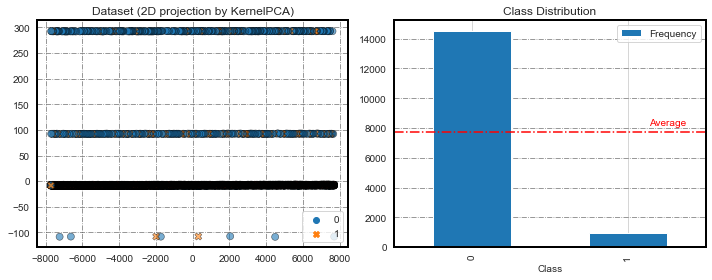

In [36]:

origin_distr = sort_dict_by_key(Counter(y_train))
test_distr = sort_dict_by_key(Counter(y_test))
print('Original training dataset shape %s' % origin_distr)
print('Original test dataset shape %s' % test_distr)

# Visualize the dataset
projection = KernelPCA(n_components=2).fit(X, y)
fig = plot_2Dprojection_and_cardinality(X, y, projection=projection)
plt.show()

## Train a SelfPacedEnsemble Classifier

### Basic usage example of SelfPacedEnsembleClassifier

In [138]:
# Train a SelfPacedEnsembleClassifier
clf = SelfPacedEnsembleClassifier(
    base_estimator=CatBoostClassifier(verbose=0), # [lightgbm_clf1,lightgbm_clf2,xgboost_clf1,xgboost_clf2,Catboost_clf1,Catboost_clf2],
    n_estimators=30,
    random_state=RANDOM_STATE
).fit(
    X_train, y_train,
    eval_datasets={'test': (X_test, y_test)},
    eval_metrics={'balanced_acc': (balanced_accuracy_score, {})},  # Customize evaluation metrics
    train_verbose=True,
)

# Predict & Evaluate
y_pred = clf.predict(X_test)

balanced_acc = balanced_accuracy_score(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)
print ('| balanced_acc {:.3f} | average_precision {:.3f} | Time {:.3f}s'.format(average_precision,balanced_acc, fit_time))

┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃             ┃                    ┃ Data: train  ┃  Data: test  ┃
┃ #Estimators ┃ Class Distribution ┃    Metric    ┃    Metric    ┃
┃             ┃                    ┃ balanced_acc ┃ balanced_acc ┃
┣━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━┫
┃      1      ┃  {0: 629, 1: 629}  ┃    0.865     ┃    0.839     ┃
┃      3      ┃  {0: 629, 1: 629}  ┃    0.892     ┃    0.867     ┃
┃      6      ┃  {0: 629, 1: 629}  ┃    0.894     ┃    0.869     ┃
┃      9      ┃  {0: 629, 1: 629}  ┃    0.895     ┃    0.870     ┃
┃     12      ┃  {0: 629, 1: 629}  ┃    0.897     ┃    0.874     ┃
┃     15      ┃  {0: 629, 1: 629}  ┃    0.898     ┃    0.878     ┃
┃     18      ┃  {0: 629, 1: 629}  ┃    0.900     ┃    0.882     ┃
┃     21      ┃  {0: 629, 1: 629}  ┃    0.900     ┃    0.883     ┃
┃     24      ┃  {0: 629, 1: 629}  ┃    0.901     ┃    0.884     ┃
┃     27      ┃  {0: 629, 1: 629}  ┃    0.902     ┃    0.885  

## Train all ensemble classifiers

In [143]:
from time import time
init_kwargs = {
    'n_estimators': 50,
    'random_state': RANDOM_STATE,
    'base_estimator':CatBoostClassifier(verbose=0)
}
fit_kwargs = {
    'X': X_train,
    'y': y_train,
}

ensembles = {
    'SelfPacedEnsemble': SelfPacedEnsembleClassifier,
    'SMOTEBagging': SMOTEBaggingClassifier,
    'SMOTEBoost': SMOTEBoostClassifier,
    'UnderBagging': UnderBaggingClassifier,
    'RUSBoost': RUSBoostClassifier,
    'BalanceCascade': BalanceCascadeClassifier,
}

fit_ensembles = {}
for ensemble_name, ensemble_class in ensembles.items():
    ensemble_clf = ensemble_class(**init_kwargs)
    print ('Training {:^20s} '.format(ensemble_name), end='')
    start_time = time()
    ensemble_clf.fit(
        X_train, y_train,
        eval_datasets={'test': (X_test, y_test)},
        eval_metrics={'balanced_acc': (balanced_accuracy_score, {})},  # Customize evaluation metrics
        train_verbose=True)
    
    
    fit_time = time() - start_time
    y_pred = ensemble_clf.predict(X_test)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    average_precision = average_precision_score(y_test, y_pred)
    print ('| balanced_acc {:.3f} | average_precision {:.3f} | Time {:.3f}s'.format(average_precision,balanced_acc, fit_time))

Training  SelfPacedEnsemble   ┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃             ┃                    ┃ Data: train  ┃  Data: test  ┃
┃ #Estimators ┃ Class Distribution ┃    Metric    ┃    Metric    ┃
┃             ┃                    ┃ balanced_acc ┃ balanced_acc ┃
┣━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━┫
┃      1      ┃  {0: 629, 1: 629}  ┃    0.865     ┃    0.839     ┃
┃      5      ┃  {0: 629, 1: 629}  ┃    0.891     ┃    0.871     ┃
┃     10      ┃  {0: 629, 1: 629}  ┃    0.894     ┃    0.874     ┃
┃     15      ┃  {0: 629, 1: 629}  ┃    0.896     ┃    0.877     ┃
┃     20      ┃  {0: 629, 1: 629}  ┃    0.896     ┃    0.878     ┃
┃     25      ┃  {0: 629, 1: 629}  ┃    0.897     ┃    0.878     ┃
┃     30      ┃  {0: 629, 1: 629}  ┃    0.899     ┃    0.882     ┃
┃     35      ┃  {0: 629, 1: 629}  ┃    0.899     ┃    0.878     ┃
┃     40      ┃  {0: 629, 1: 629}  ┃    0.900     ┃    0.879     ┃
┃     45      ┃  {0: 629, 1: 629

In [144]:
y_pred

array([1, 0, 0, ..., 0, 0, 1])

In [145]:
print('******最后效果******')

print('acc of train:',accuracy_score(y_test,y_pred))
print('auc of train:',roc_auc_score(y_test,y_pred))



******最后效果******
acc of train: 0.8702983138780804
auc of train: 0.887945898581039


# 构建selfpaced_stacking集成模型

## 构建lightGBM、GBDT、XGBoost、Catboost selfpace模型

In [87]:
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,BaggingClassifier

# Baggingselfpace mode
Bagging_selfpace_clf = SelfPacedEnsembleClassifier(
    base_estimator=BaggingClassifier(), # [lightgbm_clf1,lightgbm_clf2,xgboost_clf1,xgboost_clf2,Catboost_clf1,Catboost_clf2],
    n_estimators=5,
    random_state=RANDOM_STATE
)

# AdaBoost_selfpace mode
AdaBoost_selfpace_clf = SelfPacedEnsembleClassifier(
    base_estimator=AdaBoostClassifier(), # [lightgbm_clf1,lightgbm_clf2,xgboost_clf1,xgboost_clf2,Catboost_clf1,Catboost_clf2],
    n_estimators=5,
    random_state=RANDOM_STATE
)

# RandomForest_selfpace mode
RandomForest_selfpace_clf = SelfPacedEnsembleClassifier(
    base_estimator=RandomForestClassifier(), # [lightgbm_clf1,lightgbm_clf2,xgboost_clf1,xgboost_clf2,Catboost_clf1,Catboost_clf2],
    n_estimators=10,
    random_state=RANDOM_STATE
)

# GBDT_selfpace mode
GBDT_selfpace_clf = SelfPacedEnsembleClassifier(
    base_estimator=GBDT_clf1, # [lightgbm_clf1,lightgbm_clf2,xgboost_clf1,xgboost_clf2,Catboost_clf1,Catboost_clf2],
    n_estimators=10,
    random_state=RANDOM_STATE
)

# light_selfpace mode
lightgbm_selfpace_clf = SelfPacedEnsembleClassifier(
    base_estimator=lightgbm_clf1, # [lightgbm_clf1,lightgbm_clf2,xgboost_clf1,xgboost_clf2,Catboost_clf1,Catboost_clf2],
    n_estimators=10,
    random_state=RANDOM_STATE
)

# xgboost_selfpace mode
xgboost_selfpace_clf = SelfPacedEnsembleClassifier(
    base_estimator=xgboost_clf1, # [lightgbm_clf1,lightgbm_clf2,xgboost_clf1,xgboost_clf2,Catboost_clf1,Catboost_clf2],
    n_estimators=10,
    random_state=RANDOM_STATE
)

# catboost_selfpace mode
catboost_selfpace_clf = SelfPacedEnsembleClassifier(
    base_estimator=catboost_clf1, # [lightgbm_clf1,lightgbm_clf2,xgboost_clf1,xgboost_clf2,Catboost_clf1,Catboost_clf2],
    n_estimators=10,
    random_state=RANDOM_STATE
)

## 构建selfpace stacking模型

In [88]:
selfpace_sclf = StackingCVClassifier(classifiers=[Bagging_selfpace_clf,AdaBoost_selfpace_clf,RandomForest_selfpace_clf,GBDT_selfpace_clf,lightgbm_selfpace_clf,xgboost_selfpace_clf,catboost_selfpace_clf],
                            use_probas=True,  
                            meta_classifier=LogisticRegression(verbose=0),
                            random_state=42, cv=5,verbose=0,n_jobs=8)

In [39]:
selfpace_sclf.fit(X,y)

selfpace_stacking_pred = selfpace_sclf.predict(X_test)
selfpace_stacking_proba = selfpace_sclf.predict_proba(X_test)[:,1]
print('acc of test:',accuracy_score(y_test,selfpace_stacking_pred))
print('auc of test:',roc_auc_score(y_test,selfpace_stacking_proba))

# acc of test: 0.836042600896861
# auc of test: 0.8396242071312974

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
acc of test: 0.9939472546476438
auc of test: 0.9999607195837947


<bound method _BaseStackingClassifier.predict_proba of StackingCVClassifier(classifiers=[SelfPacedEnsembleClassifier(base_estimator=BaggingClassifier(),
                                                              n_estimators=5,
                                                              random_state=50),
                                  SelfPacedEnsembleClassifier(base_estimator=AdaBoostClassifier(),
                                                              n_estimators=5,
                                                              random_state=50),
                                  SelfPacedEnsembleClassifier(base_estimator=RandomForestClassifier(),
                                                              n_estimators=10,
                                                              random_state=50),
                                  SelfPacedEnsembleClassif...
                                                                                           n_estimators=100,

## 其他不平衡方法

In [89]:
from time import time
from imbalanced_ensemble.ensemble import SMOTEBaggingClassifier, SMOTEBoostClassifier, UnderBaggingClassifier, \
    BalanceCascadeClassifier

ensembles = {
    'SMOTEBagging': SMOTEBaggingClassifier,
    'SMOTEBoost': SMOTEBoostClassifier,
    'UnderBagging': UnderBaggingClassifier,
    'BalanceCascade': BalanceCascadeClassifier,
}

fit_ensembles = {}
for ensemble_name, ensemble_class in ensembles.items():

    # Baggingselfpace mode
    Bagging_selfpace_clf = ensemble_class(
        base_estimator=BaggingClassifier(), # [lightgbm_clf1,lightgbm_clf2,xgboost_clf1,xgboost_clf2,Catboost_clf1,Catboost_clf2],
        n_estimators=5,
        random_state=RANDOM_STATE
    )

    # AdaBoost_selfpace mode
    AdaBoost_selfpace_clf = ensemble_class(
        base_estimator=AdaBoostClassifier(), # [lightgbm_clf1,lightgbm_clf2,xgboost_clf1,xgboost_clf2,Catboost_clf1,Catboost_clf2],
        n_estimators=5,
        random_state=RANDOM_STATE
    )

    # RandomForest_selfpace mode
    RandomForest_selfpace_clf = ensemble_class(
        base_estimator=RandomForestClassifier(), # [lightgbm_clf1,lightgbm_clf2,xgboost_clf1,xgboost_clf2,Catboost_clf1,Catboost_clf2],
        n_estimators=10,
        random_state=RANDOM_STATE
    )

    # GBDT_selfpace mode
    GBDT_selfpace_clf = ensemble_class(
        base_estimator=GBDT_clf1, # [lightgbm_clf1,lightgbm_clf2,xgboost_clf1,xgboost_clf2,Catboost_clf1,Catboost_clf2],
        n_estimators=10,
        random_state=RANDOM_STATE
    )

    # light_selfpace mode
    lightgbm_selfpace_clf = ensemble_class(
        base_estimator=lightgbm_clf1, # [lightgbm_clf1,lightgbm_clf2,xgboost_clf1,xgboost_clf2,Catboost_clf1,Catboost_clf2],
        n_estimators=10,
        random_state=RANDOM_STATE
    )

    # xgboost_selfpace mode
    xgboost_selfpace_clf = ensemble_class(
        base_estimator=xgboost_clf1, # [lightgbm_clf1,lightgbm_clf2,xgboost_clf1,xgboost_clf2,Catboost_clf1,Catboost_clf2],
        n_estimators=10,
        random_state=RANDOM_STATE
    )

    # catboost_selfpace mode
    catboost_selfpace_clf = ensemble_class(
        base_estimator=catboost_clf1, # [lightgbm_clf1,lightgbm_clf2,xgboost_clf1,xgboost_clf2,Catboost_clf1,Catboost_clf2],
        n_estimators=10,
        random_state=RANDOM_STATE
    )

    
    ensembles_sclf = StackingCVClassifier(classifiers=[Bagging_selfpace_clf,AdaBoost_selfpace_clf,RandomForest_selfpace_clf,GBDT_selfpace_clf,lightgbm_selfpace_clf,xgboost_selfpace_clf,catboost_selfpace_clf],
                            use_probas=True,  
                            meta_classifier=LogisticRegression(verbose=0),
                            random_state=42, cv=5,verbose=0,n_jobs=8)
    
    
    
    print ('Training {:^20s} '.format(ensemble_name), end='')
    start_time = time()
    ensembles_sclf.fit(X_train, y_train)
    
    
    fit_time = time() - start_time
    
    ensembles_stacking_pred = ensembles_sclf.predict(X_test)
    ensembles_stacking_proba = ensembles_sclf.predict_proba(X_test)[:,1]

    print ('| acc {:.6f} | auc {:.6f}\n'.format(accuracy_score(y_test,ensembles_stacking_pred), roc_auc_score(y_test,ensembles_stacking_proba)))

Training     SMOTEBagging     | acc 0.934933 | auc 0.895588

Training      SMOTEBoost      [LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
| acc 0.952010 | auc 0.955636

Training     UnderBagging     [LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
| acc 0.935581 | auc 0.

# 模型可解释性

In [32]:
import shap
import lime

In [34]:
# 利用shap方法解释
shap.initjs()
explainer_shap = shap.KernelExplainer(catboost_clf1.predict_proba,X_train)

Using 10794 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [35]:
# 解释第j条数据
shap_values = explainer_shap.shap_values(X_test[10,:])
shap.force_plot(explainer_shap.expected_value[0],shap_values[0],X_test[10,:])

TypeError: Object of type int64 is not JSON serializable